In [1]:
# =====================================================
# CONFIGURACIÓN INICIAL Y LIBRERÍAS
# =====================================================

# Módulos estándar de Python (Built-in)
import os
import json
import random
import subprocess
import platform
import psutil
import shutil

# Librerías para Computación Numérica y Manipulación de Datos
import numpy as np
import pandas as pd
import torch

# Librerías de Machine Learning / Visión por Computadora
from ultralytics import YOLO  # Para detección/segmentación de objetos
import cv2                    # OpenCV para visión artificial
import GPUtil                   # Para obtener el estado de la GPU
from PIL import Image            # (Python Imaging Library)

# Librerías para Visualización y Métricas
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# =====================================================
# Config
# =====================================================
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
YOLO_DATASET_DIR = os.path.join(BASE_DIR, 'dataset_yolo')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(YOLO_DATASET_DIR, exist_ok=True)

# reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
# =====================================================
# Hardware / entorno
# =====================================================
print("CARACTERIZACIÓN DE HARDWARE Y ENTORNO\n" + "="*60)
print(f" - Sistema: {platform.system()} {platform.release()} ({platform.architecture()[0]})")
cpu_freq = psutil.cpu_freq()
print(f" - CPU cores physical/logical: {psutil.cpu_count(logical=False)}/{psutil.cpu_count(logical=True)}")
if cpu_freq:
    print(f" - CPU freq min/max/current: {cpu_freq.min:.2f}/{cpu_freq.max:.2f}/{cpu_freq.current:.2f} MHz")
print(f" - RAM total GB: {psutil.virtual_memory().total / (1024**3):.2f}")
if torch.cuda.is_available():
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f" - GPU: {gpu.name}  VRAM total MB: {gpu.memoryTotal:.0f}")
    print(f" - CUDA disponible: True  PyTorch CUDA version: {torch.version.cuda}")
else:
    print(" - CUDA no disponible, se usará CPU.")

print(f" - Python: {platform.python_version()}  PyTorch: {torch.__version__}")
try:
    import ultralytics
    print(f" - Ultralytics: {ultralytics.__version__}")
except Exception:
    print(" - Ultralytics: no detectado")

CARACTERIZACIÓN DE HARDWARE Y ENTORNO
 - Sistema: Windows 10 (64bit)
 - CPU cores physical/logical: 24/24
 - CPU freq min/max/current: 0.00/2700.00/2700.00 MHz
 - RAM total GB: 31.43
 - GPU: NVIDIA GeForce RTX 5080 Laptop GPU  VRAM total MB: 16303
 - CUDA disponible: True  PyTorch CUDA version: 12.8
 - Python: 3.10.18  PyTorch: 2.8.0+cu128
 - Ultralytics: 8.3.216


In [4]:
# =====================================================
# Detectar formato de anotaciones y rutas
# =====================================================
COCO_DIR = os.path.join(DATASET_DIR, 'coco')
CSV_DIR = os.path.join(DATASET_DIR, 'csv')
if os.path.exists(COCO_DIR):
    DATA_FORMAT = 'COCO'
elif os.path.exists(CSV_DIR):
    DATA_FORMAT = 'CSV'
else:
    raise FileNotFoundError("No se encontró la carpeta 'coco' ni 'csv' dentro de 'data'.")

IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, 'train')
VAL_IMAGES_DIR = os.path.join(IMAGES_DIR, 'val')
TEST_IMAGES_DIR = os.path.join(IMAGES_DIR, 'test')
YOLO_LABELS_TRAIN = os.path.join(YOLO_DATASET_DIR, 'labels', 'train')
YOLO_LABELS_VAL = os.path.join(YOLO_DATASET_DIR, 'labels', 'val')
YOLO_LABELS_TEST = os.path.join(YOLO_DATASET_DIR, 'labels', 'test')
for d in [YOLO_LABELS_TRAIN, YOLO_LABELS_VAL, YOLO_LABELS_TEST]:
    os.makedirs(d, exist_ok=True)

In [5]:
# =====================================================
# Verificación de fugas y conteo imágenes
# =====================================================
def verificar_conjuntos(train_dir, val_dir, test_dir):
    train_imgs = set(os.listdir(train_dir)) if os.path.exists(train_dir) else set()
    val_imgs = set(os.listdir(val_dir)) if os.path.exists(val_dir) else set()
    test_imgs = set(os.listdir(test_dir)) if os.path.exists(test_dir) else set()
    print(f"Train: {len(train_imgs)} imágenes")
    print(f"Val:   {len(val_imgs)} imágenes")
    print(f"Test:  {len(test_imgs)} imágenes")
    inter_train_val = train_imgs.intersection(val_imgs)
    inter_train_test = train_imgs.intersection(test_imgs)
    inter_val_test = val_imgs.intersection(test_imgs)
    if inter_train_val or inter_train_test or inter_val_test:
        print("ALERTA: Se detectaron posibles fugas de datos entre conjuntos.")
        if inter_train_val: print(f" Coincidencias train/val: {len(inter_train_val)}")
        if inter_train_test: print(f" Coincidencias train/test: {len(inter_train_test)}")
        if inter_val_test: print(f" Coincidencias val/test: {len(inter_val_test)}")
    else:
        print("Verificación completada: sin fugas detectadas entre train, val y test.")

verificar_conjuntos(TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR)

Train: 4901 imágenes
Val:   111 imágenes
Test:  258 imágenes
Verificación completada: sin fugas detectadas entre train, val y test.


In [6]:
# =====================================================
# Conversión COCO/CSV -> etiquetas YOLO
# =====================================================
def coco_to_yolo(coco_file, images_dir, output_labels_dir):
    with open(coco_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    images = {img['id']: img for img in data.get('images', [])}
    for ann in data.get('annotations', []):
        img_id = ann['image_id']
        if img_id not in images:
            continue
        img_info = images[img_id]
        img_name = img_info['file_name']
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            continue
        img_w = img_info.get('width', 1)
        img_h = img_info.get('height', 1)
        bbox = ann['bbox']  # [x,y,w,h]
        category_id = ann['category_id'] - 1
        x_center = (bbox[0] + bbox[2] / 2) / img_w
        y_center = (bbox[1] + bbox[3] / 2) / img_h
        width = bbox[2] / img_w
        height = bbox[3] / img_h
        label_path = os.path.join(output_labels_dir, os.path.splitext(img_name)[0] + '.txt')
        with open(label_path, 'a', encoding='utf-8') as f:
            f.write(f"{int(category_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def csv_to_yolo(csv_file, images_dir, output_labels_dir):
    df = pd.read_csv(csv_file)
    for _, row in df.iterrows():
        img_name = row['image']
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            continue
        class_id = int(row['class_id'])
        x_center = ((row['xmin'] + row['xmax']) / 2) / row['width']
        y_center = ((row['ymin'] + row['ymax']) / 2) / row['height']
        width = (row['xmax'] - row['xmin']) / row['width']
        height = (row['ymax'] - row['ymin']) / row['height']
        label_path = os.path.join(output_labels_dir, os.path.splitext(img_name)[0] + '.txt')
        with open(label_path, 'a', encoding='utf-8') as f:
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

if DATA_FORMAT == 'COCO':
    coco_to_yolo(os.path.join(COCO_DIR, 'train', 'train_annotations.json'), TRAIN_IMAGES_DIR, YOLO_LABELS_TRAIN)
    coco_to_yolo(os.path.join(COCO_DIR, 'val', 'val_annotations.json'), VAL_IMAGES_DIR, YOLO_LABELS_VAL)
    coco_to_yolo(os.path.join(COCO_DIR, 'test', 'test_annotations.json'), TEST_IMAGES_DIR, YOLO_LABELS_TEST)
else:
    csv_to_yolo(os.path.join(CSV_DIR, 'train', 'train_annotations.csv'), TRAIN_IMAGES_DIR, YOLO_LABELS_TRAIN)
    csv_to_yolo(os.path.join(CSV_DIR, 'val', 'val_annotations.csv'), VAL_IMAGES_DIR, YOLO_LABELS_VAL)
    csv_to_yolo(os.path.join(CSV_DIR, 'test', 'test_annotations.csv'), TEST_IMAGES_DIR, YOLO_LABELS_TEST)

In [7]:
# =====================================================
# Generar dataset.yaml
# =====================================================
if DATA_FORMAT == 'COCO':
    coco_train_file = os.path.join(COCO_DIR, 'train', 'train_annotations.json')
    with open(coco_train_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    categories = [c['name'] for c in data.get('categories', [])]
    class_names = categories if categories else ['animal']
    nc = len(class_names)
else:
    csv_train_file = os.path.join(CSV_DIR, 'train', 'train_annotations.csv')
    df = pd.read_csv(csv_train_file)
    if 'class_name' in df.columns:
        class_names = sorted(df['class_name'].unique().tolist())
    else:
        unique_ids = sorted(df['class_id'].unique().tolist())
        class_names = [f"class_{i}" for i in unique_ids]
    nc = len(class_names)

yaml_content = f"""
path: {YOLO_DATASET_DIR.replace(os.sep, '/')}
train: images/train
val: images/val
test: images/test
nc: {nc}
names: {class_names}
"""
yaml_path = os.path.join(YOLO_DATASET_DIR, 'dataset.yaml')
with open(yaml_path, 'w', encoding='utf-8') as f:
    f.write(yaml_content)
print(f"Archivo dataset.yaml generado con {nc} clases en: {yaml_path}")

Archivo dataset.yaml generado con 6 clases en: C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\dataset.yaml


Se detectaron 9 imágenes sin anotaciones en train (background).


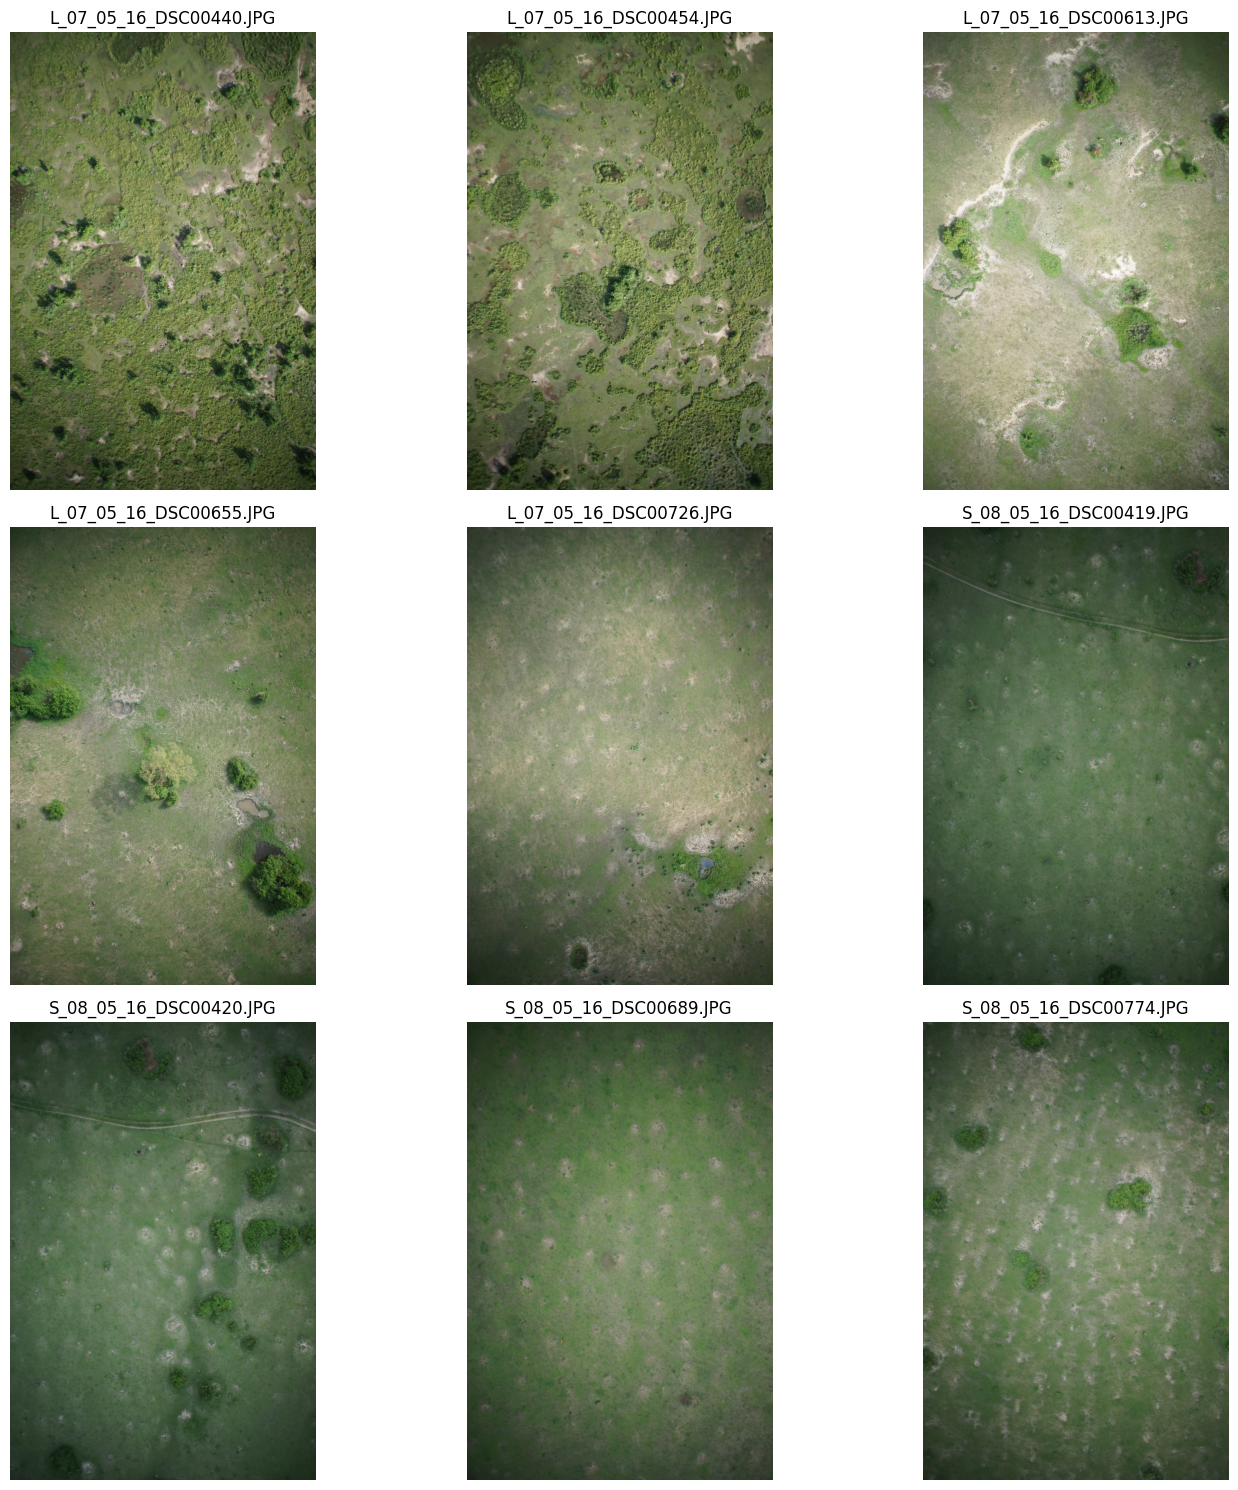

In [8]:
# =====================================================
# Validaciones finales y limpieza básica
# =====================================================
def limpiar_etiquetas(labels_dir, nc):
    for file in os.listdir(labels_dir):
        if not file.endswith('.txt'):
            continue
        file_path = os.path.join(labels_dir, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        valid_lines = []
        for l in lines:
            parts = l.strip().split()
            if not parts:
                continue
            try:
                class_id = int(float(parts[0]))
                if 0 <= class_id < nc:
                    valid_lines.append(f"{class_id} " + " ".join(parts[1:]) + "\n")
            except ValueError:
                print(f"Advertencia: línea inválida en {file}: {l.strip()}")
        if len(valid_lines) < len(lines):
            with open(file_path, 'w', encoding='utf-8') as f:
                f.writelines(valid_lines)
            print(f"Corregido: {file}")

# Ejecutar limpieza
limpiar_etiquetas(YOLO_LABELS_TRAIN, nc)
limpiar_etiquetas(YOLO_LABELS_VAL, nc)
limpiar_etiquetas(YOLO_LABELS_TEST, nc)

# detectar imágenes background (sin anotaciones)
background_images = []
for img_file in os.listdir(TRAIN_IMAGES_DIR):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_name = os.path.splitext(img_file)[0]
    label_path = os.path.join(YOLO_LABELS_TRAIN, img_name + '.txt')
    if not os.path.exists(label_path) or os.path.getsize(label_path) == 0:
        background_images.append(img_file)

print(f"Se detectaron {len(background_images)} imágenes sin anotaciones en train (background).")

# Mostrar imágenes background en grid de 3 columnas
cols = 3
rows = (len(background_images) + cols - 1) // cols  # Redondear hacia arriba

plt.figure(figsize=(15, 5 * rows))
for i, img_file in enumerate(background_images):
    img_path = os.path.join(TRAIN_IMAGES_DIR, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convertir BGR a RGB para matplotlib
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# =====================================================
# Copiar imágenes a estructura YOLO si hace falta
# =====================================================
YOLO_IMAGES_TRAIN = os.path.join(YOLO_DATASET_DIR, 'images', 'train')
YOLO_IMAGES_VAL = os.path.join(YOLO_DATASET_DIR, 'images', 'val')
YOLO_IMAGES_TEST = os.path.join(YOLO_DATASET_DIR, 'images', 'test')
for d in [YOLO_IMAGES_TRAIN, YOLO_IMAGES_VAL, YOLO_IMAGES_TEST]:
    os.makedirs(d, exist_ok=True)

def asegurar_imagenes(origen, destino):
    if not os.path.exists(origen):
        print(f"Advertencia: no existe origen {origen}")
        return
    files = [f for f in os.listdir(origen) if os.path.isfile(os.path.join(origen, f))]
    if not files:
        print(f"Advertencia: no hay imágenes en {origen}")
        return
    if len(os.listdir(destino)) == 0:
        for f in files:
            shutil.copy2(os.path.join(origen, f), os.path.join(destino, f))

asegurar_imagenes(TRAIN_IMAGES_DIR, YOLO_IMAGES_TRAIN)
asegurar_imagenes(VAL_IMAGES_DIR, YOLO_IMAGES_VAL)
asegurar_imagenes(TEST_IMAGES_DIR, YOLO_IMAGES_TEST)
print("Estructura YOLO preparada.")

Estructura YOLO preparada.


In [10]:
# =====================================================
# Cargar modelo (reanudar si existe checkpoint)
# =====================================================
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'yolov11m_training')
LAST_CHECKPOINT = os.path.join(CHECKPOINT_DIR, 'weights', 'last.pt')  # si existe, resume
if os.path.exists(LAST_CHECKPOINT):
    print("Checkpoint detectado. Reanudando desde:", LAST_CHECKPOINT)
    model = YOLO(LAST_CHECKPOINT)
else:
    print("Entrenamiento desde pesos base yolo11m.")
    model = YOLO('yolo11m.pt')

Entrenamiento desde pesos base yolo11m.


In [11]:
# =====================================================
# Parámetros de entrenamiento optimizados
# =====================================================

device = 0 if torch.cuda.is_available() else 'cpu'

train_kwargs = dict(
    data=yaml_path,
    epochs=50,                 # entrenamiento estable y controlado
    imgsz=640,                 # resolución ajustada --> mejor generalización
    batch=16,                   # mantiene estabilidad sin saturar VRAM
    lr0=0.02,                  # learning rate ajustado para SGD
    lrf=0.001,                 # tasa final de decaimiento
    weight_decay=5e-4,         # regularización L2
    optimizer='SGD',           # recomendado para entrenamientos prolongados
    momentum=0.937,            # valor empírico óptimo (Ultralytics)
    warmup_epochs=3,           # previene inestabilidad inicial
    close_mosaic=15,           # desactiva mosaic en últimas épocas
    patience=10,               # early stopping moderado
    device=device,
    project=OUTPUT_DIR,
    name='yolov11m_optimized',
    save=True,
    resume=os.path.exists(LAST_CHECKPOINT),
    cache='disk',              # mejora velocidad en reentrenamientos
    workers=4,
    pretrained=True,           # usa pesos base
    save_period=1,             # guardar checkpoints por época
    deterministic=True,        # reproducibilidad total
    seed=SEED,
)

# =====================================================
# Hiperparámetros adicionales (augmentaciones y pérdidas)
# =====================================================

# Si la API no acepta directamente estos parámetros,
# definirlos en un archivo hyp.yaml y pasarlos con model.train(hyp='hyp.yaml')

extra_hparams = {
    "mosaic": 1.0,             # activado --> mejora recall
    "mixup": 1.0,              # diversidad sintética
    "degrees": 0.0,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 0.0,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "label_smoothing": 0.1,
    "box": 8.0,
    "cls": 0.5,
    "dfl": 1.5,
    "obj": 1.5,
}

train_kwargs.update(dict(augment=True))

In [12]:
# =====================================================
# Ejecutar entrenamiento
# =====================================================
print("Iniciando entrenamiento con los siguientes kwargs:")
for k, v in train_kwargs.items():
    print(f" - {k}: {v}")
results = model.train(**train_kwargs)

Iniciando entrenamiento con los siguientes kwargs:
 - data: C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\dataset.yaml
 - epochs: 50
 - imgsz: 640
 - batch: 16
 - lr0: 0.02
 - lrf: 0.001
 - weight_decay: 0.0005
 - optimizer: SGD
 - momentum: 0.937
 - warmup_epochs: 3
 - close_mosaic: 15
 - patience: 10
 - device: 0
 - project: C:\Users\durle\anaconda3\Fauna_Detection\outputs
 - name: yolov11m_optimized
 - save: True
 - resume: False
 - cache: disk
 - workers: 4
 - pretrained: True
 - save_period: 1
 - deterministic: True
 - seed: 42
 - augment: True
New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.216  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5080 Laptop GPU, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_past

2025/10/27 16:04:43 INFO mlflow.tracking.fluent: Experiment with name 'C:\Users\durle\anaconda3\Fauna_Detection\outputs' does not exist. Creating a new experiment.
2025/10/27 16:04:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


MLflow: logging run_id(dfa6d422a6094ff7a87903d434ae190c) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to C:\Users\durle\anaconda3\Fauna_Detection\outputs\yolov11m_optimized
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      8.08G      2.272      3.292      1.027         35        640: 100% ━━━━━━━━━━━━ 307/307 3.0it/s 1:43<0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.4it/s 2.8s0.3ss
                   all        111        978     0.0359      0.188     0.0466     0.0129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50       8.1G      2.481      2.403      1.049         49        640: 100% ━━━━━━━━━━━━ 307/307 3

In [13]:
# =====================================================
# Guardado final y calibración de scores 
# =====================================================
# Guardar mejor checkpoint por mAP50-95 y realizar calibración de scores (temperature scaling / isotonic)
print("Entrenamiento finalizado. Revisar outputs en:", os.path.join(OUTPUT_DIR, 'yolov11m_optimized'))

Entrenamiento finalizado. Revisar outputs en: C:\Users\durle\anaconda3\Fauna_Detection\outputs\yolov11m_optimized


In [14]:
# ================================
# EVALUACIÓN CONJUNTO DE VALIDACIÓN
# ================================

# Buscar automáticamente el directorio de checkpoints dentro de OUTPUT_DIR
def find_checkpoint_dir(output_dir, name_hint='yolov11m_optimized'):
    # Prioriza carpeta con el mismo name_hint, si no existe tomar el primer subdirectorio con /weights
    cand = os.path.join(output_dir, name_hint)
    if os.path.isdir(cand):
        return cand
    # buscar subdirector que contenga weights
    for root, dirs, files in os.walk(output_dir):
        if 'weights' in dirs:
            return os.path.join(root)
    return None

# obtener CHECKPOINT_DIR real (sobrescribe si es necesario)
CHECKPOINT_DIR = find_checkpoint_dir(OUTPUT_DIR, name_hint='yolov11m_optimized')
if CHECKPOINT_DIR is None:
    raise FileNotFoundError(f"No se encontró carpeta de checkpoints bajo {OUTPUT_DIR}. Revisa que el entrenamiento haya creado outputs/*/weights.")

# construir rutas a best/last dentro de la carpeta weights
WEIGHTS_DIR = os.path.join(CHECKPOINT_DIR, 'weights')
best_ckpt = os.path.join(WEIGHTS_DIR, 'best.pt')
last_ckpt = os.path.join(WEIGHTS_DIR, 'last.pt')

# elegir checkpoint disponible (best prioridad)
if os.path.exists(best_ckpt):
    ckpt_to_use = best_ckpt
elif os.path.exists(last_ckpt):
    ckpt_to_use = last_ckpt
else:
    # mostrar contenido esperado para debugging
    existing = []
    if os.path.isdir(WEIGHTS_DIR):
        existing = os.listdir(WEIGHTS_DIR)
    raise FileNotFoundError(f"No se encontró best.pt ni last.pt en {WEIGHTS_DIR}. Archivos presentes: {existing}")

print("Validando con checkpoint:", ckpt_to_use)
model_val = YOLO(ckpt_to_use)

# Ejecuta validación estricta sobre el conjunto de validación
val_results = model_val.val(data=yaml_path, split='val', imgsz=train_kwargs.get('imgsz', 640), batch=train_kwargs.get('batch', 16), device=device)

# Mostrar y guardar métricas si están disponibles
print("Resultados de validación (raw):")
print(val_results)

try:
    # ultralytics puede devolver un dict o un objeto con .metrics
    metrics_obj = None
    if isinstance(val_results, dict):
        metrics_obj = val_results
    elif hasattr(val_results, 'metrics'):
        metrics_obj = val_results.metrics
    if isinstance(metrics_obj, dict):
        os.makedirs(WEIGHTS_DIR, exist_ok=True)
        out_path = os.path.join(WEIGHTS_DIR, 'val_metrics.json')
        with open(out_path, 'w', encoding='utf-8') as f:
            json.dump(metrics_obj, f, indent=2)
        print("Métricas de validación guardadas en:", out_path)
except Exception as e:
    print("No se pudieron guardar métricas automáticamente:", e)

Validando con checkpoint: C:\Users\durle\anaconda3\Fauna_Detection\outputs\yolov11m_optimized\weights\best.pt
Ultralytics 8.3.216  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5080 Laptop GPU, 16303MiB)
YOLO11m summary (fused): 125 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1164.1218.3 MB/s, size: 9945.6 KB)
val: Scanning C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\labels\val.cache... 111 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 111/111  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.1it/s 6.6s0.2s
                   all        111        978      0.392      0.235      0.259     0.0785
          Alcelaphinae         29        369      0.599      0.344      0.387      0.112
               Buffalo         11        102      0.411      0.422      0.419      0.124
                   Kob         22        161       0.41     

In [15]:
# ================================
# EVALUACIÓN CONJUNTO DE TEST 
# ================================
if best_ckpt is None:
    raise FileNotFoundError("No se encontró checkpoint para test. Entrene primero y genere best.pt o last.pt.")

print("Evaluando en TEST con checkpoint:", best_ckpt)
model_test = YOLO(best_ckpt)

# Ejecuta evaluación sobre split 'test' y guarda resultados
test_results = model_test.val(data=yaml_path, split='test', imgsz=train_kwargs.get('imgsz', 640), batch=train_kwargs.get('batch', 16), device=device)

print("Resultados de test (raw):")
print(test_results)
try:
    if hasattr(test_results, 'metrics') and isinstance(test_results.metrics, dict):
        with open(os.path.join(CHECKPOINT_DIR, 'test_metrics.json'), 'w', encoding='utf-8') as f:
            json.dump(test_results.metrics, f, indent=2)
        print("Métricas de test guardadas en:", os.path.join(CHECKPOINT_DIR, 'test_metrics.json'))
except Exception:
    pass

Evaluando en TEST con checkpoint: C:\Users\durle\anaconda3\Fauna_Detection\outputs\yolov11m_optimized\weights\best.pt
Ultralytics 8.3.216  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5080 Laptop GPU, 16303MiB)
YOLO11m summary (fused): 125 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1499.0185.4 MB/s, size: 6992.0 KB)
val: Scanning C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\labels\test... 258 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 258/258 1.9Kit/s 0.1s<0.1s
val: New cache created: C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\labels\test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.9it/s 5.8s0.1s
                   all        258       2299     0.0624     0.0136     0.0126    0.00389
          Alcelaphinae         44        675          0          0          0          0
               Buffalo         22  

In [16]:
# =====================================================
# CÁLCULO DE MÉTRICAS POR CLASE Y GLOBALES
# =====================================================
from collections import defaultdict
from sklearn.metrics import average_precision_score, mean_absolute_error, mean_squared_error
import yaml as _yaml
from PIL import Image
import numpy as np
import os

# Helpers
def read_dataset_yaml(yaml_path):
    with open(yaml_path, 'r', encoding='utf-8') as f:
        return _yaml.safe_load(f)

def list_images_in_split(split):
    ds = read_dataset_yaml(yaml_path)
    rel = ds['val'] if split == 'val' else ds['test']
    split_dir = os.path.join(YOLO_DATASET_DIR, rel)
    return split_dir, [f for f in os.listdir(split_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

def to_xyxy_from_yolo_label(xc, yc, w, h, img_w, img_h):
    x1 = (xc - w/2) * img_w
    y1 = (yc - h/2) * img_h
    x2 = (xc + w/2) * img_w
    y2 = (yc + h/2) * img_h
    return [x1, y1, x2, y2]

def safe_get_boxes_from_result(r):
    preds = []
    try:
        boxes = r.boxes
        xyxy = getattr(boxes, 'xyxy', None)
        confs = getattr(boxes, 'conf', None)
        clss = getattr(boxes, 'cls', None)
        if xyxy is not None:
            xyxy_np = xyxy.cpu().numpy() if hasattr(xyxy, 'cpu') else np.array(xyxy)
            confs_np = confs.cpu().numpy() if hasattr(confs, 'cpu') else np.array(confs)
            clss_np = clss.cpu().numpy() if hasattr(clss, 'cpu') else np.array(clss)
            for i in range(len(xyxy_np)):
                preds.append((int(clss_np[i]), float(confs_np[i]), xyxy_np[i].tolist()))
            return preds
    except Exception:
        pass
    try:
        for b in r.boxes:
            try:
                c = int(getattr(b, 'cls').cpu().numpy()) if hasattr(getattr(b, 'cls'), 'cpu') else int(getattr(b, 'cls'))
                cf = float(getattr(b, 'conf').cpu().numpy()) if hasattr(getattr(b, 'conf'), 'cpu') else float(getattr(b, 'conf'))
                xy = getattr(b, 'xyxy').cpu().numpy().tolist() if hasattr(getattr(b, 'xyxy'), 'cpu') else getattr(b, 'xyxy')
                preds.append((c, cf, xy))
            except Exception:
                continue
        return preds
    except Exception:
        return []

# Collect detections
def collect_detections(model_ckpt, split='val', imgsz=640, conf_thresh=0.001):
    detector = YOLO(model_ckpt)
    split_dir, img_files = list_images_in_split(split)
    results_list = []
    for img_file in img_files:
        img_path = os.path.join(split_dir, img_file)
        results = detector.predict(source=img_path, imgsz=imgsz, conf=conf_thresh, iou=0.5, batch=1)
        if len(results) == 0:
            preds = []
        else:
            r = results[0]
            preds = safe_get_boxes_from_result(r)
        label_dir = YOLO_LABELS_VAL if split == 'val' else YOLO_LABELS_TEST
        label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
        gts = []
        if os.path.exists(label_path):
            with Image.open(img_path) as im:
                img_w, img_h = im.size
            with open(label_path, 'r', encoding='utf-8') as f:
                for l in f:
                    parts = l.strip().split()
                    if len(parts) < 5:
                        continue
                    cid = int(float(parts[0]))
                    xc, yc, bw, bh = map(float, parts[1:5])
                    gbox = to_xyxy_from_yolo_label(xc, yc, bw, bh, img_w, img_h)
                    gts.append((cid, gbox))
        results_list.append({'image': img_file, 'gt': gts, 'pred': preds})
    return results_list

# IoU and matching
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA); interH = max(0, yB - yA)
    inter = interW * interH
    boxAArea = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    boxBArea = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    union = boxAArea + boxBArea - inter
    return inter / union if union > 0 else 0.0

def compute_per_class_metrics(results_list, n_classes, iou_threshold=0.5):
    per_class = {i: {'tp':0,'fp':0,'fn':0,'y_true':[], 'y_score':[]} for i in range(n_classes)}
    for item in results_list:
        gts = item['gt'].copy()
        preds = sorted(item['pred'], key=lambda x: x[1], reverse=True)
        matched_gt = set()
        for p_cls, p_conf, p_box in preds:
            best_j = -1; best_iou = 0.0
            for j, (g_cls, g_box) in enumerate(gts):
                if j in matched_gt: continue
                if p_cls != g_cls: continue
                cur_iou = iou(p_box, g_box)
                if cur_iou >= iou_threshold and cur_iou > best_iou:
                    best_iou = cur_iou; best_j = j
            if best_j >= 0:
                per_class[p_cls]['tp'] += 1
                matched_gt.add(best_j)
                per_class[p_cls]['y_true'].append(1); per_class[p_cls]['y_score'].append(p_conf)
            else:
                per_class[p_cls]['fp'] += 1
                per_class[p_cls]['y_true'].append(0); per_class[p_cls]['y_score'].append(p_conf)
        for j, (g_cls, _) in enumerate(gts):
            if j not in matched_gt:
                per_class[g_cls]['fn'] += 1
                per_class[g_cls]['y_true'].append(1); per_class[g_cls]['y_score'].append(0.0)
    summary = {}
    aps = []
    for c in range(n_classes):
        tp=per_class[c]['tp']; fp=per_class[c]['fp']; fn=per_class[c]['fn']
        precision = tp/(tp+fp) if tp+fp>0 else 0.0
        recall = tp/(tp+fn) if tp+fn>0 else 0.0
        f1 = 2*precision*recall/(precision+recall) if precision+recall>0 else 0.0
        y_true = per_class[c]['y_true']; y_score = per_class[c]['y_score']
        ap = average_precision_score(y_true, y_score) if len(set(y_true))>1 else 0.0
        summary[c] = {'precision':precision,'recall':recall,'f1':f1,'AP':ap,'tp':tp,'fp':fp,'fn':fn}
        aps.append(ap)
    mAP = float(np.mean(aps)) if len(aps)>0 else 0.0
    return summary, mAP

# Ejecutar (VAL y TEST)
n_classes = nc
print("Recolectando predicciones VAL (esto puede tardar según N imágenes)...")
val_dets = collect_detections(ckpt_to_use, split='val', imgsz=train_kwargs.get('imgsz',896), conf_thresh=0.001)
print("Computando métricas por clase VAL...")
val_summary, val_mAP = compute_per_class_metrics(val_dets, n_classes, iou_threshold=0.5)
for c, s in val_summary.items():
    print(f"VAL Class {c} ({class_names[c]}): prec={s['precision']:.3f}, rec={s['recall']:.3f}, f1={s['f1']:.3f}, AP={s['AP']:.3f}, tp={s['tp']},fp={s['fp']},fn={s['fn']}")
print(f"mAP@0.5 (VAL) = {val_mAP:.3f}")

print("Recolectando predicciones TEST (esto puede tardar según N imágenes)...")
test_dets = collect_detections(ckpt_to_use, split='test', imgsz=train_kwargs.get('imgsz',896), conf_thresh=0.001)
print("Computando métricas por clase TEST...")
test_summary, test_mAP = compute_per_class_metrics(test_dets, n_classes, iou_threshold=0.5)
for c, s in test_summary.items():
    print(f"TEST Class {c} ({class_names[c]}): prec={s['precision']:.3f}, rec={s['recall']:.3f}, f1={s['f1']:.3f}, AP={s['AP']:.3f}, tp={s['tp']},fp={s['fp']},fn={s['fn']}")
print(f"mAP@0.5 (TEST) = {test_mAP:.3f}")

# Conteo MAE / RMSE por imagen 
def counts_from_results(results_list):
    gt_counts=[]; pred_counts=[]
    for it in results_list:
        gt_counts.append(len(it['gt']))
        pred_counts.append(len([p for p in it['pred'] if p[1] >= 0.001]))
    return np.array(gt_counts), np.array(pred_counts)

gt_val, pred_val = counts_from_results(val_dets)
if len(gt_val) > 0:
    mae_val = mean_absolute_error(gt_val, pred_val)
    rmse_val = np.sqrt(mean_squared_error(gt_val, pred_val))
else:
    mae_val, rmse_val = None, None
print(f"Conteo VAL: MAE={mae_val:.3f} RMSE={rmse_val:.3f}" if mae_val is not None else "Conteo VAL: sin muestras")

gt_test, pred_test = counts_from_results(test_dets)
if len(gt_test) > 0:
    mae_test = mean_absolute_error(gt_test, pred_test)
    rmse_test = np.sqrt(mean_squared_error(gt_test, pred_test))
else:
    mae_test, rmse_test = None, None
print(f"Conteo TEST: MAE={mae_test:.3f} RMSE={rmse_test:.3f}" if mae_test is not None else "Conteo TEST: sin muestras")

Recolectando predicciones VAL (esto puede tardar según N imágenes)...

image 1/1 C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\images\val\005c952ba7a612c40986806cc84a87e1573ef4f2.JPG: 448x640 1 Warthog, 75 Elephants, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 6.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\images\val\031833f31b1622ec6701b7433a1664231f401d73.JPG: 448x640 61 Elephants, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\images\val\06db812d2aa7a35df81d6ea9e073fee93666f65b.JPG: 448x640 27 Elephants, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\images\val\07b5ba4a21ca4a6b781b79f568d315a85d58ade3.JPG: 448x640 7 Elephants, 7.5ms
Speed: 2.2ms preprocess, 7.5ms

In [17]:
# =====================================================
# COMPARACIÓN CON REFERENTE HerdNet (Delplanque et al., 2023)
# =====================================================
# Referencia HerdNet (ULiège benchmark): F1=83.5%, MAE=1.9, RMSE=3.6
herdnet = {'F1': 0.835, 'MAE': 1.9, 'RMSE': 3.6, 'source': 'Delplanque et al., 2023 (ULiège benchmark)'}

# Extraer métricas agregadas de TEST calculadas arriba
# Para F1 global calcular macro-F1 promedio de clases o weighted según soporte
def macro_f1_from_summary(summary):
    f1s = [summary[c]['f1'] for c in summary]
    return float(np.mean(f1s))

f1_test_macro = macro_f1_from_summary(test_summary)
print("Comparación resumida con HerdNet (ULiège):")
print(f" HerdNet: F1={herdnet['F1']*100:.2f}%, MAE={herdnet['MAE']:.2f}, RMSE={herdnet['RMSE']:.2f}")
print(f" YOLO (este experimento, TEST): macro-F1={f1_test_macro*100:.2f}%, MAE={mae_test:.2f}, RMSE={rmse_test:.2f}, mAP@0.5={test_mAP:.3f}")

# Interpretación automática básica
if f1_test_macro >= herdnet['F1']:
    print("Resultado: la métrica macro-F1 del modelo YOLO es igual o superior al referente HerdNet en este experimento.")
else:
    print("Resultado: la métrica macro-F1 del modelo YOLO es inferior al referente HerdNet; requiere mejoras para alcanzar el benchmark.")

# Mostrar diferencias absolutas
diff_f1 = f1_test_macro - herdnet['F1']
diff_mae = (mae_test - herdnet['MAE']) if mae_test is not None else None
diff_rmse = (rmse_test - herdnet['RMSE']) if rmse_test is not None else None
print(f"Diferencias (YOLO - HerdNet): F1={diff_f1:.3f}, MAE={diff_mae:.3f}, RMSE={diff_rmse:.3f}")

Comparación resumida con HerdNet (ULiège):
 HerdNet: F1=83.50%, MAE=1.90, RMSE=3.60
 YOLO (este experimento, TEST): macro-F1=0.68%, MAE=33.83, RMSE=59.16, mAP@0.5=0.215
Resultado: la métrica macro-F1 del modelo YOLO es inferior al referente HerdNet; requiere mejoras para alcanzar el benchmark.
Diferencias (YOLO - HerdNet): F1=-0.828, MAE=31.933, RMSE=55.556
